In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
df = pd.read_csv('Finance.csv')

# Basic statistics
df.describe(include='all')

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Check class distribution of target variable
df['Loan_Status'].value_counts(normalize=True)

# Visualize missing values
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

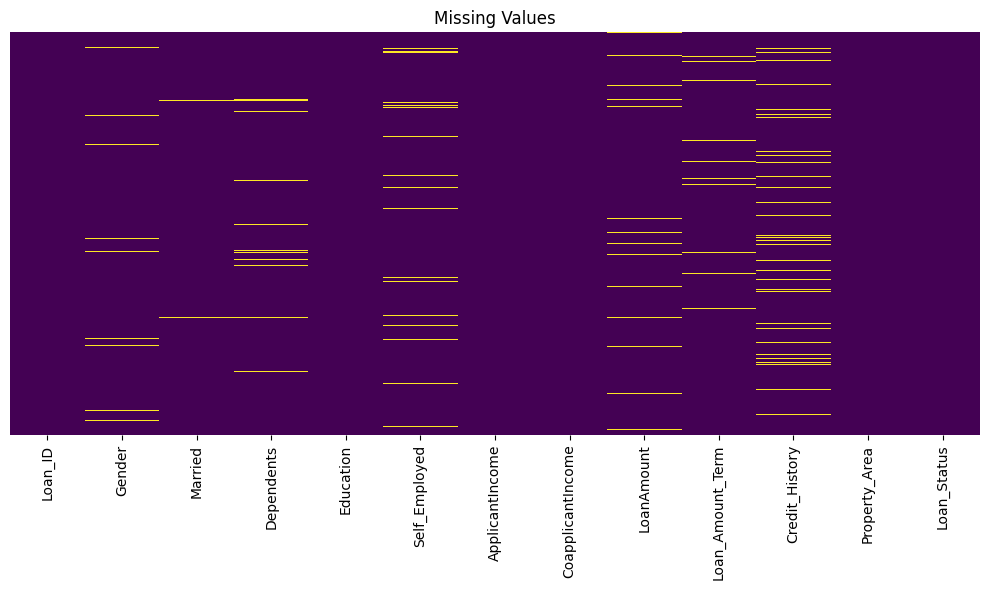

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values')
plt.tight_layout()


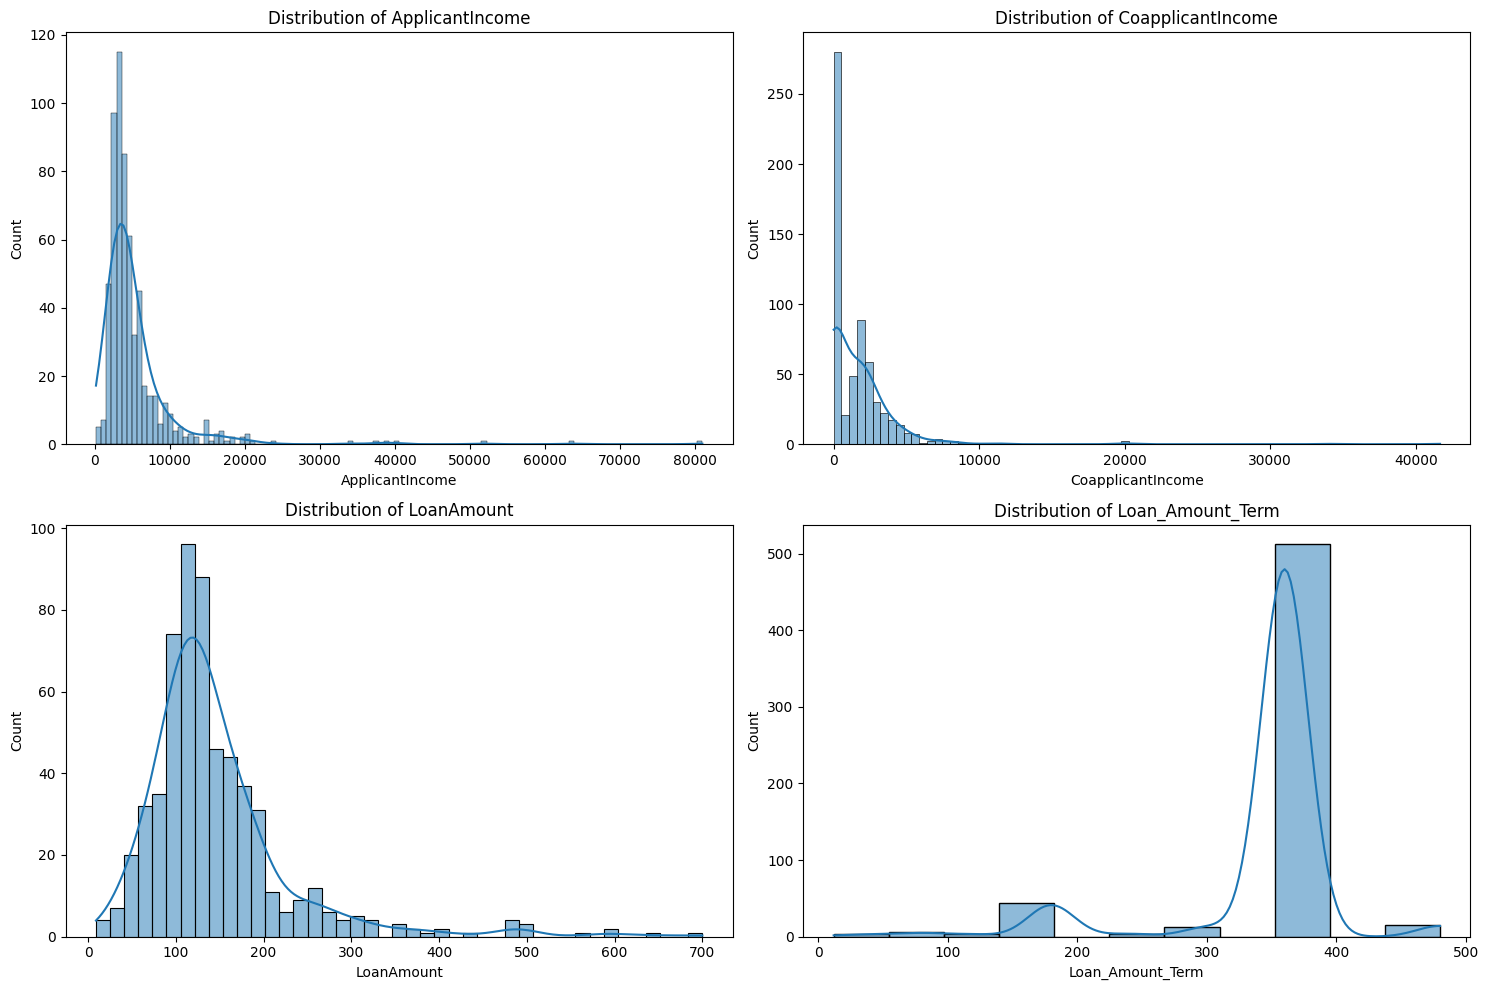

In [5]:
# Distribution of numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', ]):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

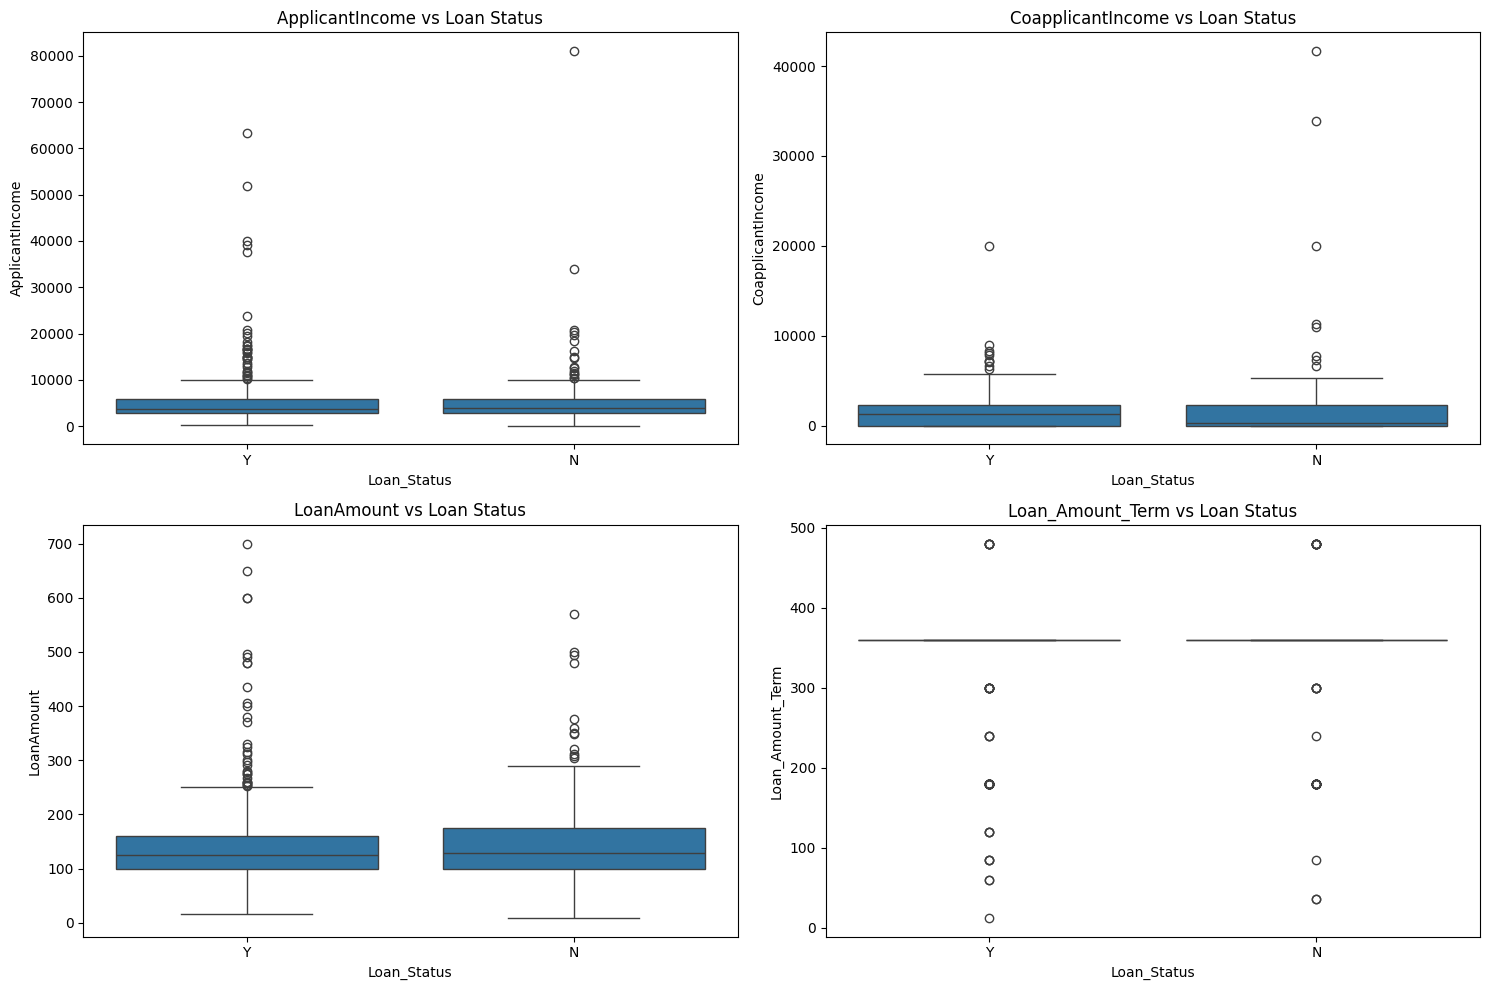

In [6]:
# Relationship between numerical features and target
plt.figure(figsize=(15, 10))
for i, col in enumerate(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Loan_Status', y=col, data=df)
    plt.title(f'{col} vs Loan Status')
plt.tight_layout()

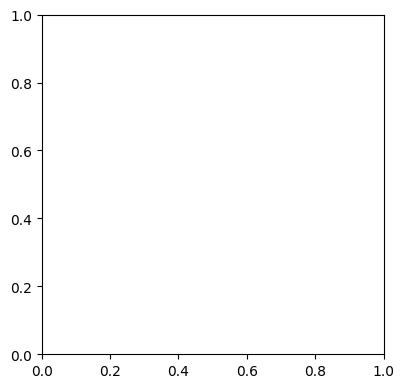

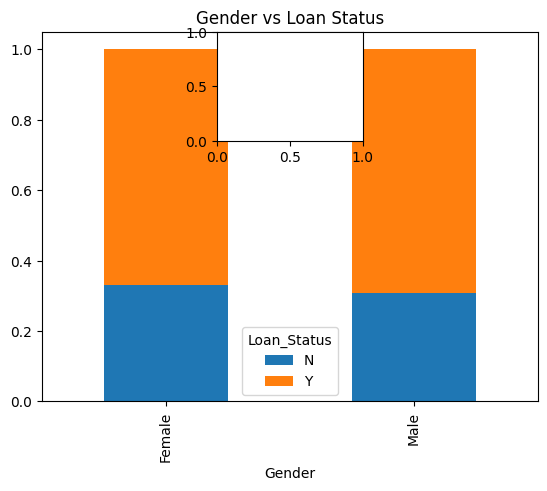

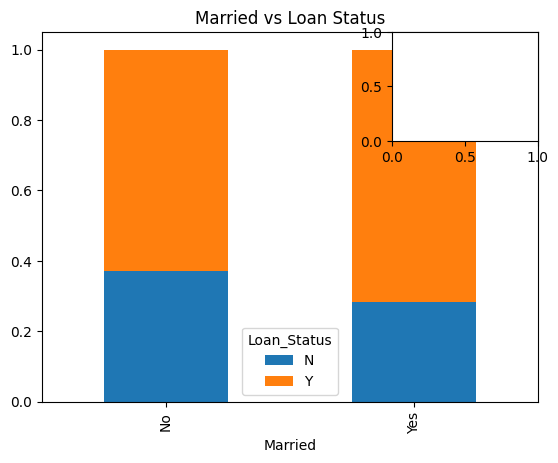

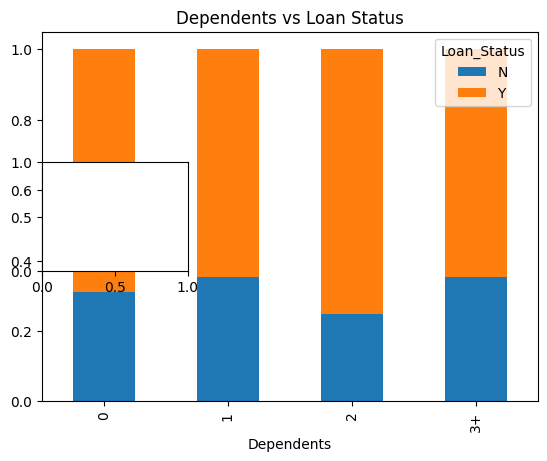

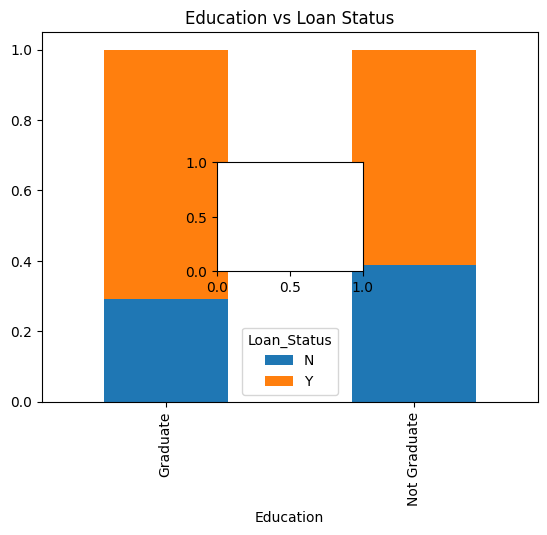

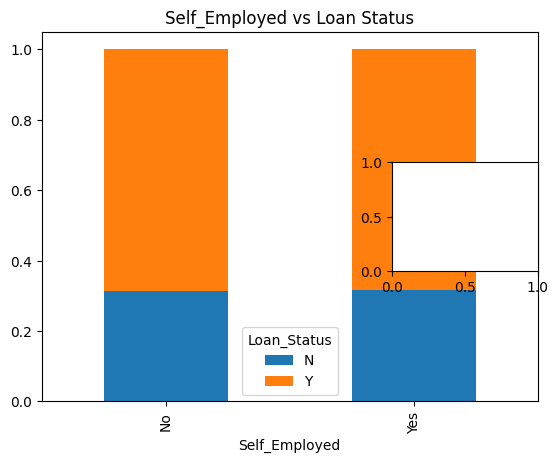

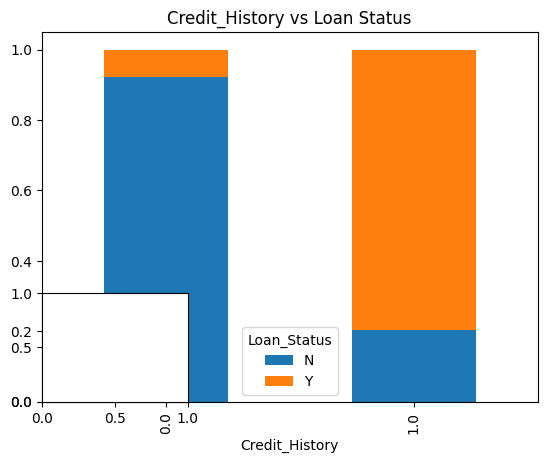

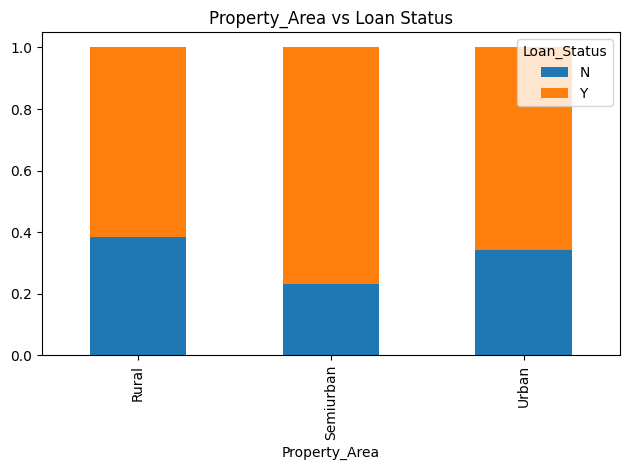

In [7]:
# Categorical features analysis
plt.figure(figsize=(15, 15))
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Credit_History', 'Property_Area']
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)
    cross_tab = pd.crosstab(df[col], df['Loan_Status'], normalize='index')
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Loan Status')
plt.tight_layout()

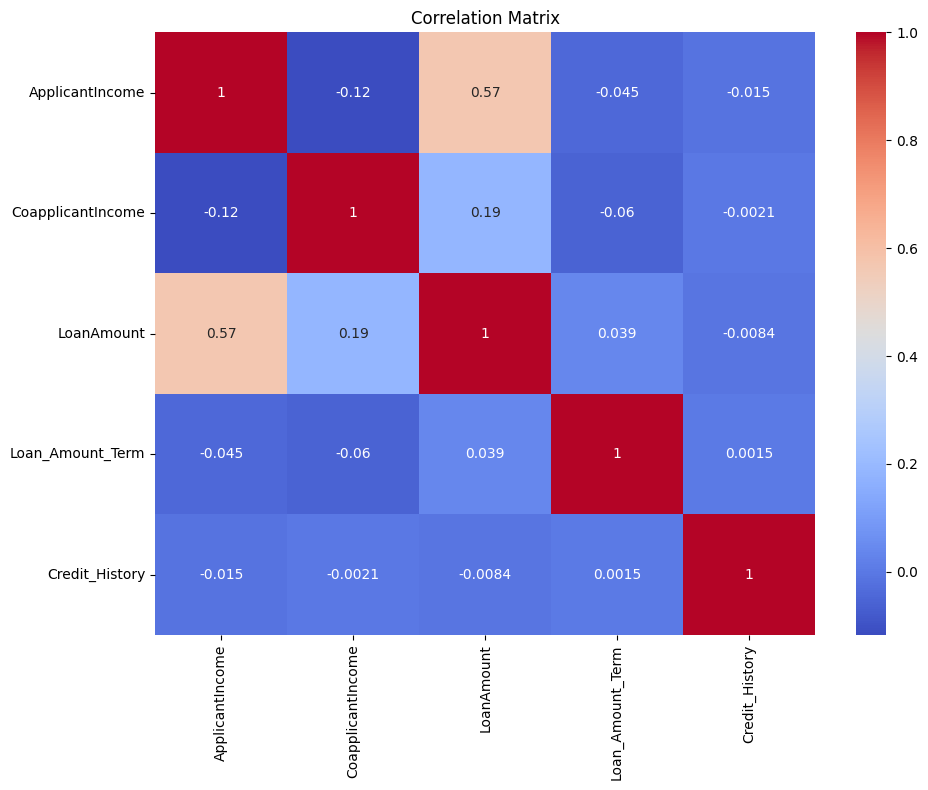

In [8]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()


In [10]:
# Impute categorical variables with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Property_Area']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

In [11]:
# Impute numerical variables with median (more robust to outliers than mean)
for col in ['LoanAmount', 'Loan_Amount_Term']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())


In [13]:
# Create Total Income feature
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Create income to loan ratio
df['Income_to_Loan_Ratio'] = df['TotalIncome'] / df['LoanAmount']

# Log transformation for skewed numerical features
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome']:
    df[f'Log_{col}'] = np.log1p(df[col])  # log1p handles zero values

# Convert 'Dependents' to numerical
df['Dependents'] = df['Dependents'].replace('3+', '3')
df['Dependents'] = pd.to_numeric(df['Dependents'])

# Convert Loan_Status to binary (target encoding)
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# One-hot encoding for categorical variables
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [14]:
from sklearn.preprocessing import StandardScaler


In [15]:
# Scale numerical features
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                 'Loan_Amount_Term', 'TotalIncome', 'Income_to_Loan_Ratio',
                 'Log_ApplicantIncome', 'Log_CoapplicantIncome', 'Log_LoanAmount', 'Log_TotalIncome']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

# Select top k features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)


Selected features: ['CoapplicantIncome', 'LoanAmount', 'Credit_History', 'TotalIncome', 'Log_CoapplicantIncome', 'Log_LoanAmount', 'Married_Yes', 'Education_Not Graduate', 'Property_Area_Semiurban', 'Property_Area_Urban']


In [17]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Check for imbalance
print(df['Loan_Status'].value_counts())


Loan_Status
1    422
0    192
Name: count, dtype: int64


In [18]:
# Option 1: SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [19]:
# Option 2: Upsampling minority class
if df['Loan_Status'].value_counts()[0] != df['Loan_Status'].value_counts()[1]:
    # Separate majority and minority classes
    df_majority = df[df['Loan_Status']==df['Loan_Status'].value_counts().idxmax()]
    df_minority = df[df['Loan_Status']==df['Loan_Status'].value_counts().idxmin()]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=42)


In [22]:
# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Define models to try
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [29]:
# Compare models with cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")


LogisticRegression CV Accuracy: 0.8111 (+/- 0.0276)
RandomForest CV Accuracy: 0.7964 (+/- 0.0229)
GradientBoosting CV Accuracy: 0.7948 (+/- 0.0222)
XGBoost CV Accuracy: 0.7931 (+/- 0.0143)


Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.8186
Test Accuracy: 0.7886

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.49      0.62        43
           1       0.78      0.95      0.85        80

    accuracy                           0.79       123
   macro avg       0.81      0.72      0.74       123
weighted avg       0.80      0.79      0.77       123


Confusion Matrix:
[[21 22]
 [ 4 76]]


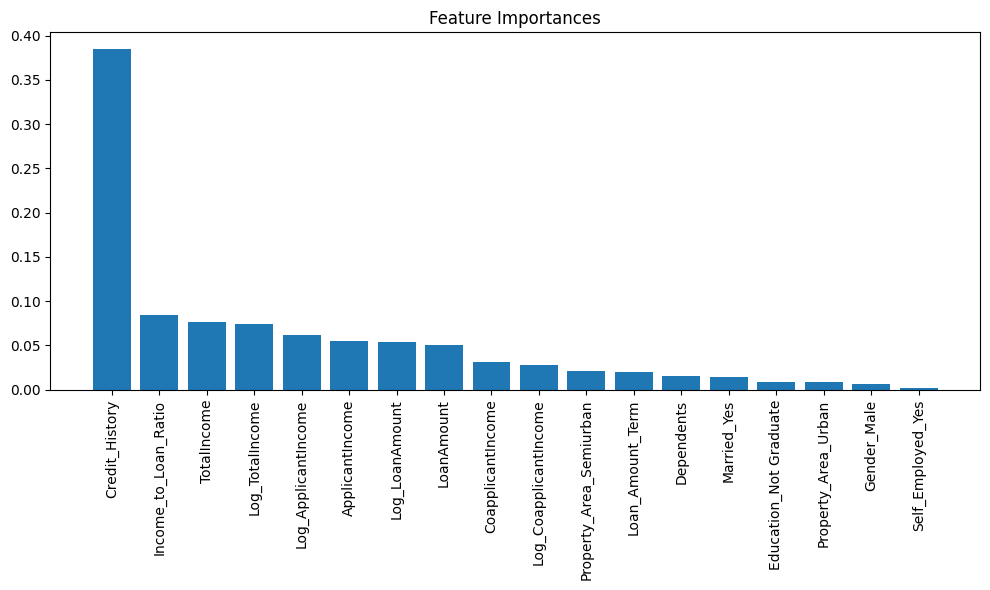

In [32]:
# Hyperparameter tuning for best model (example for RandomForest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                          param_grid=param_grid,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.tight_layout()
